# Distributed clustering

We have many types of distributed clustering, where most are an modification of k-means. In this section we show three types: hard k-means (hcm), fuzzy k-means (fcm) and possibilistic k-means (pcm).

### Libraries

We need four libraries. Numpy is used for the matrices calculation. The math library is used to calcualte the square root when we calculate the Euclidean distance. Matplotlib is used for the plots. Finally, pandas is used here only for displaying the assignation matrix in a easy to ready form in Jupyter.

In [17]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd

## K-means

The most known method is called k-means and assign each case to one cluster strictly. It is also known as hard c-means where k is the same as c and are the number of clusters that we are willing to divide the data set to. The steps of hcm are like following:
1. choose the entrance cluster centroids,
2. item calculate the assignation matrix $U$,
3. item calculate new centroids matrix $V$,
4. calculate the difference between previously assignation matrix $U$ and the new one calculated in current iteration.

In [18]:
%store -r data_set

Before we start, we should setup a few variables like the assignation matrix, number of clusters, the error margin and feature space:

In [19]:
groups = 2
error_margin = 0.01
m=2
assignation=np.zeros((len(data_set),groups))
assignation

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

The error margin is a value of error that below ends the clustering loop. 

The assignation matrix if filled with zeros as we don't have any guess for assignation yet. We can also fill it randomly with 1 and 0 for each group. The assignation matrix looks like following:

\begin{equation*}
U=\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix}.
\end{equation*}


It's time to generate centroid array randomly:
\begin{equation}
 V=[v_{1},v_{2},\ldots,v_{c}].
\end{equation}

We go through each group and add a random array of the feature space centroid positions:

In [20]:
def select_centers():
    return np.random.rand(groups,len(data_set[0]))
        
centers = select_centers()
centers

array([[0.43164261, 0.33588192],
       [0.91335534, 0.46545331]])

Let's take a look what centroids do we have:

In [21]:
pd.DataFrame(centers, columns=['x1','x2'])

,x1,x2
0,0.431643,0.335882
1,0.913355,0.465453


We can also set fixed centers. It is important that the values are normalized.

In [22]:
#centers = [[0.2,0.2],  [0.8,0.8]]
#pd.DataFrame(centers)
#print(centers)

To check what is the distance between the centroids and the elements of data set we use the Euclidean distance:

\begin{equation}
 \rho_{Min}(x_{i},v_{j})=\sqrt{\sum_{i=1}^{d}(x_{i}-v_{j})^{2}}.
\end{equation}

In [23]:
def calculate_distance(x,v):
    return sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)

The next step is to calculate the new assignation matrix:

\begin{equation}
 \mu_{ik}^{(t)}=
 \begin{cases}
 1 & \text{if } d(x_{k},v_{i})<d(x_{k},v_{j}),  \text{for each } j\neq i\\
 0 & \text{in other case} \\
 \end{cases}.
\end{equation}

The code below relizes the equation above for two groups.

In [24]:
def calculate_u(x, centers):
    if calculate_distance(x, centers[0]) < calculate_distance(x, centers[1]):
        return [1,0]
    else:
        return [0,1]

The third step is to calculate new centroids based on the new assignation matrix $U$:

\begin{equation}
 v_{i}=\frac{\sum_{k=1}^{M}\mu_{ik}^{(t)}x_{k}}{\sum_{k=1}^{M}\mu_{ik}^{(t)}}.
\end{equation}

The calculation is done in two steps: ```u_x_vector``` and ```u_scalar```:

In [25]:
def calculate_new_centers(u):
    new_centers=[]
    for c in range(groups):
        u_x_vector=np.zeros(2)
        u_scalar=0.0
        for i in range(len(data_set)):
            u_scalar = u_scalar+(u[i][c]**m)
            u_x_vector=np.add(u_x_vector,np.multiply(u[i][c]**m,data_set[i]))
        new_centers.append(np.divide(u_x_vector,u_scalar))
    return new_centers

We are almost done here. The last step before we cluster is to set the rule that allow us to stop the loop.

In [26]:
def calculate_differences(new_assignation, assignation):     
    return np.sum(np.abs(np.subtract(assignation,new_assignation)))

It's time to combine all together:

In [27]:
def cluster_hcm(assignation,centers):
    difference_limit_not_achieved=True
    new_centers = centers
    iter=0
    while difference_limit_not_achieved:
        new_assignation=[]
        for i in range(len(data_set)):
            new_assignation.append(calculate_u(data_set[i], new_centers))
        new_centers = calculate_new_centers(new_assignation)
        if iter>0:
            if calculate_differences(new_assignation, assignation) < error_margin:
                difference_limit_not_achieved=False
        assignation=new_assignation
        iter=iter+1
    return new_assignation, new_centers

Ready to build some new clusters: 

In [28]:
new_assignation_hcm, new_centers_hcm = cluster_hcm(assignation, centers)
%store new_assignation_hcm
%store new_centers_hcm

Stored 'new_assignation_hcm' (list)
Stored 'new_centers_hcm' (list)


The centers are like following:

In [29]:
pd.DataFrame(new_centers_hcm, columns=['x1','x2'])

,x1,x2
0,0.127701,0.207853
1,0.829077,0.970594


And the assignation matrix looks like:

In [30]:
pd.DataFrame(new_assignation_hcm, columns = ['Cluster 1','Cluster 2'])

,Cluster 1,Cluster 2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,0,1
7,0,1
8,0,1
9,1,0


To plot it, we need to develop a short function that adds some colors to our plot:

In [31]:
red = data_set[np.where(np.array(new_assignation_hcm)[:,0]==1)]
blue = data_set[np.where(np.array(new_assignation_hcm)[:,1]==1)]

And finally plot the results:

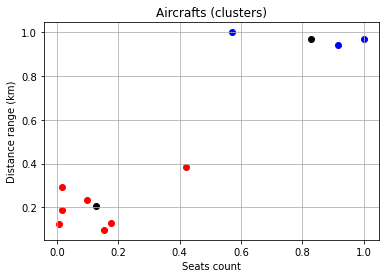

In [32]:
fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='blue')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(np.array(new_centers_hcm)[:,0],np.array(new_centers_hcm)[:,1],c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()


## Fuzzy k-means

We reset the assignation matrix and set the m parameter. The m paramtere is also known as fuzzifier. The higher value it is the values are more fuzzy. A lower value gives as results that are closer to the one that we got with the hard version of k-means.

In [33]:
assignation=np.zeros((len(data_set),groups))

m = 2.0

The fuzzy implementation of k-means is a bit more complex and we need to modify the calculate_u function to be complient with the equation:

\begin{equation}
 \mu_{ik}=(\sum_{j=1}^{c}(\frac{d(x_{k},v_{i})}{d(x_{k},v_{j})})^{\frac{2}{m-1}})^{-1}
\end{equation}

The implementation is given as below.

In [34]:
def calculate_u_fcm(x, centers, group_id):
    distance_centers = 0
    for group in range(groups):        
        if group != group_id:
            distance_centers+= calculate_distance(x, centers[group])
    distance_sum=1.0+(calculate_distance(x, centers[group_id])/distance_centers)**m
    return distance_sum**-1

That's the only difference between HCM and FCM. The rest is almost the same in both cases.

In [35]:
def cluster_fcm(assignation, centers):
    difference_limit_not_achieved=True
    new_centers = centers
    iter=0
    while difference_limit_not_achieved:
        new_assignation=[]
        for i in range(len(data_set)):
            new_assignation_vector=[]
            for k in range(groups):
                new_assignation_vector.append(calculate_u_fcm(data_set[i],new_centers,k))
            new_assignation.append(new_assignation_vector)
        new_centers = calculate_new_centers(new_assignation)

        if iter>0:
            if calculate_differences(new_assignation, assignation) < error_margin:
                difference_limit_not_achieved=False
        assignation=new_assignation
        iter=iter+1
    return new_assignation, new_centers

Calculation of the clusters is done the same way as in the previous example:

In [36]:
new_assignation_fcm, new_centers_fcm = cluster_fcm(assignation, centers)

The cluster centers are similar to the previous example:

In [37]:
pd.DataFrame(new_centers_hcm, columns=['x1','x2'])

,x1,x2
0,0.127701,0.207853
1,0.829077,0.970594


The assignation matrix is different even we assign same objects to the same clusters. Values in each row sums to 1.

In [38]:
pd.DataFrame(new_assignation_fcm, columns = ['Cluster 1','Cluster 2'])

,Cluster 1,Cluster 2
0,0.988102,0.011898
1,0.992838,0.007162
2,0.983861,0.016139
3,0.990161,0.009839
4,0.992115,0.007885
5,0.998551,0.001449
6,0.006033,0.993967
7,0.019703,0.980297
8,0.077282,0.922718
9,0.792864,0.207136


To plot the objects in a fuzzy k-means we need to group them by values higher than 0.5 as both values sums to 1.

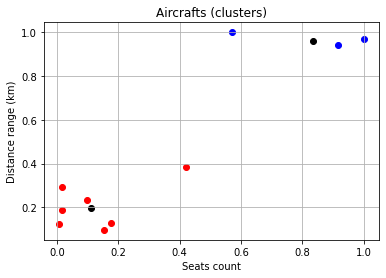

In [39]:
red = data_set[np.where(np.array(new_assignation_fcm)[:,0]>0.5)]
blue = data_set[np.where(np.array(new_assignation_fcm)[:,1]>0.5)]

fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='blue')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(np.array(new_centers_fcm)[:,0],np.array(new_centers_fcm)[:,1],c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()

### Possibilistic k-means (PCM)

In the fuzzy version, each row sums to 1. In real-world cases, it doesn't need to be like this. The possibilistic k-means returns the distance to the center rather than dividing the assignation between clusters.


As suggested by the authors, the initial assignation matrix should be created using the FCM method. We do a fixed number of FCM method loops. The number of loops is set by the variable ``F``. The ``error_margin`` variable is the error threshold were below of it we stop the loop.

In [40]:
F = 2
error_margin = 0.08
assignation=np.zeros((len(data_set),groups))

The assignation function is more complex compared to the two previous one. In PCM we use the Mahalanobis distance instead of the Euclidean one, and the assignation function is set as:
\begin{equation}
 \mu_{ik}=(1+(\frac{\rho_{A}(x_{i},v_{j})}{\eta_{i}})^{\frac{2}{m-1}})^{-1},
\end{equation}
where
\begin{equation}
\eta_{i}=\frac{\sum_{k=1}^{M}(\mu_{ik})^{m}\rho_{A}(x_{i},v_{j})}{\sum_{k=1}^{M}(\mu_{ik}
)^{m}}.
\end{equation}
$\rho_{A}(x_{i},v_{j})$ is the Mahalanobis distance:
\begin{equation}
\rho_{A}(x_{i},v_{j})=(x_{i}-v_{j})^{T}A(x_{i}-v_{j}).
\end{equation}
It use ``A`` diagnoal matrix to measure the distance. The figure below show how the euclidean distance is measured:
![](./../images/euclidean.png)
The difference between two distances is that in Mahalanobis distance we use the diagonal matrix ``A``, which is also known as Mahalanobis norm, that allow us to measure the distance between objects as it's shown in figure below.
![](./../images/mahalanobis.png)

The Mahalanobis norm can be implemented as below.

In [41]:
def calculate_A():
    mean=np.mean(data_set,axis=0)
    sumof = np.zeros((data_set[0].shape))
    for i in range(len(data_set)):
        subtracted = np.subtract(data_set[i],mean)
        sumof = sumof + np.multiply(subtracted, subtracted)
    variance = np.divide(sumof,len(data_set))
    ABcov = np.cov(data_set[:,0]*data_set[:,1])
    R = np.array([[variance[0], ABcov], [ABcov, variance[1]]])
    return R**-1

The matrix can be saved as global variable ``A``. It is the size of the feature number by feature number. In our case it will be a matrix of size $2\times2$.

In [42]:
A = calculate_A()
print(A)


[[7.89464944 6.69665317]
 [6.69665317 7.75894855]]


After getting the ``A`` matrix, we are able to calcualte the Mahalanobis distance. The ``A`` matrix is calculated once, because it depends on the whole data set, not the method steps.

In [43]:
def calculate_mah_distance(group, centers):
    dmc = data_set - centers[group]
    dmca = np.dot(data_set - centers[group], A)

    distances = lambda dmc, dmca: [np.dot(dmca[i], dmc[i]) for i in range(dmc.shape[0])]
    print(dmc.shape[0])
    return distances(dmc,dmca)

The $\eta$ can be implemented as below:

In [44]:
def calculate_eta(assignation, group, mah_distances):
    ud = np.sum((assignation[:, group] ** m) * mah_distances, axis=0)
    uq = np.sum(assignation[:, group] ** m, axis=0)
    return ud/uq

Finally, we can calculate the $\nu$:

In [45]:
def calculate_u_pcm(assignation, centers):
    new_assignation = np.zeros((len(data_set), groups))
    for group in range(groups):
        mah_distances = calculate_mah_distance(group, centers)
        group_eta = calculate_eta(assignation, group, mah_distances)
        new_assignation[:,group] = (1.0+(mah_distances/group_eta)**2)**-1
    return new_assignation

A stop function in PCM is defined as the difference between old and newly calculated centers.

In [46]:
def get_centers_difference(old_centers, new_centers):
    return np.sum(np.abs(np.subtract(old_centers,new_centers)))    

The ``cluster_pcm`` function has two parts. The first one is a FCM method that returns the input assignation matrix for the PCM method.

In [47]:
def cluster_pcm(assignation, centers):
    new_centers = centers
    new_assignation = assignation
    for f in range(F):
        assignation = []
        for i in range(len(data_set)):
            assignation_vector = []
            for k in range(groups): 
                assignation_vector.append(calculate_u_fcm(data_set[i], new_centers, k))
            assignation.append(assignation_vector)
        new_centers = calculate_new_centers(assignation)
        new_assignation = np.array(assignation)

        
    difference_limit_not_achieved = True
    while difference_limit_not_achieved:
        new_assignation = calculate_u_pcm(new_assignation, new_centers)
        old_centers = new_centers
        new_centers = calculate_new_centers(new_assignation)

        if get_centers_difference(old_centers, new_centers) < error_margin:
            difference_limit_not_achieved = False
    return new_assignation, new_centers

Now, we can cluster the data set with PCM:

In [48]:
new_assignation_pcm, new_centers_pcm = cluster_pcm(assignation, centers)

10
10
10
10


The assignation values does not sum to 1 as in fuzzy k-means. The matrix give a better understanding of where the object is placed in the feature space.

In [49]:
pd.DataFrame(new_assignation_pcm, columns = ['Cluster 1','Cluster 2'])

,Cluster 1,Cluster 2
0,0.041676,0.000015
1,0.391462,0.000017
2,0.585574,0.000023
3,0.765232,0.000020
4,0.763004,0.000023
5,0.644261,0.000024
6,0.000003,0.999982
7,0.000002,0.526785
8,0.000007,0.013007
9,0.000248,0.000106


In case of PCM we decided to extend the plot for many groups, up to 6. The colors are defined below.

In [50]:
assigned_groups = []
colors = ['red','blue','green','orange','black','yellow']

for el in range(len(data_set)):
    group_id = np.argmax(new_assignation_pcm[el])
    assigned_groups.append(group_id)


We need a function that assign a color to each cluster.

In [51]:
def get_colours(color_id):
    return data_set[np.where(np.array(assigned_groups)[:]==color_id)]

Finally, we go through groups we have and assign objects to colors and plot it. What is important to mention is that some assignation values for an object can be very low, means that this object is far from all centers. We can implement here a threshold where if all assignation values are below some threshold we treat such objects as noise. In the figure below, we see the last object that is closer to the red centroid, but was assigned to the blue cluster. In this case both values are very low, but the blue one is just a bit higher. In a hard k-means method it wouldn't be so easy to find the noise.

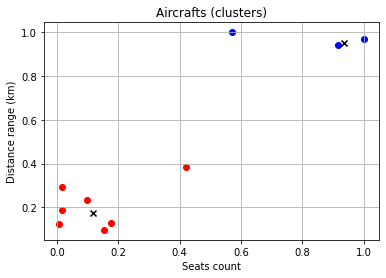

In [52]:
fig, ax = plt.subplots()


for group in range(groups):
    small_set = get_colours(group)
    ax.scatter(small_set[:,0],small_set[:,1],c=colors.pop(0))
ax.scatter(np.array(new_centers_pcm)[:,0],np.array(new_centers_pcm)[:,1],marker='x',c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()